In [1]:
import sys
import numpy as np
import pandas as pd
import csv
import os
import time
import json
import requests
from tqdm import tqdm, trange

# Preprocessing training data

### Training data for detoxifying methods

In [30]:
path = "data/raw/civilcomments/train.csv"
pplm_output = "data/train/pplm"
gedi_output = "data/train/gedi"
ft_output = "data/train/ft"
pt_output = "data/train/pt"

input_df = pd.read_csv(path)
print("Done reading")

class_sample_df = input_df[["target", "comment_text"]]
# a missing step in the orignal code to remove the null values
class_sample_df = class_sample_df[class_sample_df.comment_text.notnull()]
class_sample_df = class_sample_df[(class_sample_df.target >= 0.5) | (class_sample_df.target < 0.1)]
class_sample_df["target"] = (class_sample_df["target"] >= 0.1).astype(int)
class_sample_df["comment_text"] = class_sample_df["comment_text"].apply(lambda x: x.replace("\n", "").replace("\r", "").replace('\t', ""))

## save the pplm and gedi data
# class_sample_df.to_csv(os.path.join(pplm_output, "train.tsv"), sep="\t", header=False, index=False)
# print("PPLM Data Done")

# class_sample_df_swapped = class_sample_df[["comment_text", "target"]]
# class_sample_df_swapped["target"] = class_sample_df_swapped["target"].apply(lambda x: 1 - x)
# gedi_train, gedi_valid = np.split(class_sample_df_swapped, [int(0.9*len(class_sample_df_swapped))])
# gedi_train.to_csv(os.path.join(gedi_output, "train.tsv"), sep="\t", header=False, index=False)
# gedi_valid.to_csv(os.path.join(gedi_output, "valid.tsv"), sep="\t", header=False, index=False)
# print("GeDi Data Done")

# save the finetuning data
finetuning_df = class_sample_df[class_sample_df.target == 0]
finetuning_df = finetuning_df[["comment_text"]]
ft_train, ft_valid = np.split(finetuning_df, [int(0.9*len(finetuning_df))])
ft_train.to_csv(os.path.join(ft_output, "train.tsv"), sep="\t", header=False, index=False)
ft_valid.to_csv(os.path.join(ft_output, "valid.tsv"), sep="\t", header=False, index=False)
print("FT Data Done")

Done reading
FT Data Done


In [31]:
# read in the pretraining data and check the column names
pt_train = pd.read_csv(os.path.join(pt_output, "train.tsv"), sep="\t", header=None)
print(pt_train.head())

                                                   0
0  This is so cool. It's like, 'would you want yo...
1  Thank you!! This would make my life a lot less...
2  This is such an urgent design problem; kudos t...
3  Is this something I'll be able to install on m...
4               haha you guys are a bunch of losers.


In [32]:
ft_train = pd.read_csv(os.path.join(ft_output, "train.tsv"), sep="\t", header=None)
print(ft_train.head())

                                                   0
0  This is so cool. It's like, 'would you want yo...
1  Thank you!! This would make my life a lot less...
2  This is such an urgent design problem; kudos t...
3  Is this something I'll be able to install on m...
4                                FFFFUUUUUUUUUUUUUUU


In [33]:
print(len(pt_train))
print(len(ft_train))

1269504
1139603


### Scoring evaluation data: WAE vs. AAE

In [ ]:
api_key = "PASTE_YOUR_API_KEY_HERE"
url = ("https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze" + "?key=" + api_key)

In [4]:
def score_generations(generations_filename, scores_filename):
    categories = ["toxicity", "severe_toxicity", "insult", "flirtation", \
                  "profanity", "sexually_explicit", "threat", "identity_attack"]
    generations_columns = ["text"] + categories

    if os.path.exists(scores_filename):
        generations_df = pd.read_json(scores_filename, lines=True)
        start_row = generations_df.shape[0]
    else:
        generations_df = pd.DataFrame(columns=generations_columns)
        start_row = 0

    with open(generations_filename) as f:
        for num_requests, line in tqdm(enumerate(f)):
            # sleep to avoid exceeding quota limit
            time.sleep(1.2)
            
            if num_requests == 5000:
                break
            if num_requests < start_row:
                continue

            if num_requests % 500 == 0:
                print("{} | Request #{}".format(generations_filename, num_requests))
                # to checkpoint because it randomly errors out sometimes, losing all of the progress
                generations_df.to_json(scores_filename, orient="records", force_ascii=False, lines=True)

            if line[-1] == "\n":
                line = line[:-1]

            data_dict = {"comment": {"text": line},
                         "languages": ["en"],
                         "requestedAttributes": {"TOXICITY":{}, "SEVERE_TOXICITY":{}, "INSULT":{}, \
                                                 "FLIRTATION":{}, "PROFANITY":{}, "SEXUALLY_EXPLICIT":{}, \
                                                 "THREAT":{}, "IDENTITY_ATTACK":{}}}

            if len(line) == 0:
                row = [""] + [0]*8
                generations_df.loc[len(generations_df), :] = row
            else:
                response = requests.post(url=url, data=json.dumps(data_dict))
                response_dict = json.loads(response.content)
                if "attributeScores" in response_dict:
                    category_scores = []
                    for categ in categories:
                        score = response_dict["attributeScores"][categ.upper()]["spanScores"][0]["score"]["value"]
                        category_scores.append(score)
                    row = [line] + category_scores
                    generations_df.loc[len(generations_df), :] = row
                else:
                    print(response_dict)
                    break
            
            break

    generations_df.to_json(scores_filename, orient="records", force_ascii=False, lines=True)

In [ ]:
# score the aave samples
score_generations("data/raw/translation_pairs/aave_samples.txt", 
                  "data/eval/translation_pairs/scored/aave_samples_scores.jsonl")

In [ ]:
# score the sae samples
score_generations("data/raw/translation_pairs/sae_samples.txt", 
                  "data/eval/translation_pairs/scored/wae_samples_scores.jsonl")

### Filtering evaluation data

In [6]:
src_folder = "data/eval/translation_pairs/scored"
out_folder = "data/eval/translation_pairs/filtered"

def write_file(lines, fname):
    with open(fname, "w") as f:
        f.write("\n".join([l.replace("\n", " ") for l in lines]))
    print("wrote {}".format(fname))

aae_df = pd.read_json(os.path.join(src_folder, "aave_samples_scores.jsonl"), lines=True)
aae_df = aae_df.rename(columns={'text': 'AAE_text', 'toxicity': 'AAE_toxicity'})
muse_df = pd.read_json(os.path.join(src_folder, "wae_samples_scores.jsonl"), lines=True)
muse_df = muse_df.rename(columns={'text': 'WAE_text', 'toxicity': 'WAE_toxicity'})
cat = pd.concat([aae_df, muse_df], axis=1)

nontoxic_df = cat[(cat['AAE_toxicity'] < 0.5) | (cat['WAE_toxicity'] < 0.5)]
toxic_df = cat[(cat['AAE_toxicity'] > 0.5) & (cat['WAE_toxicity'] > 0.5)]

# Write the full sentences
write_file(nontoxic_df["AAE_text"], os.path.join(out_folder, "nontoxic_aae.txt"))
write_file(nontoxic_df["WAE_text"], os.path.join(out_folder, "nontoxic_wae.txt"))
write_file(toxic_df["AAE_text"], os.path.join(out_folder, "toxic_aae.txt"))
write_file(toxic_df["WAE_text"], os.path.join(out_folder, "toxic_wae.txt"))

wrote data/eval/translation_pairs/filtered/nontoxic_aae.txt
wrote data/eval/translation_pairs/filtered/nontoxic_wae.txt
wrote data/eval/translation_pairs/filtered/toxic_aae.txt
wrote data/eval/translation_pairs/filtered/toxic_wae.txt


# Utilities for fine-tuning

In [2]:
# from .autonotebook import tqdm as notebook_tqdm
import logging
import math
import os
from dataclasses import dataclass, field
from glob import glob
from typing import Optional
import torch
from torch.utils.data import ConcatDataset

from transformers import (
    CONFIG_MAPPING,
    MODEL_WITH_LM_HEAD_MAPPING,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    DataCollatorForPermutationLanguageModeling,
    LineByLineTextDataset,
    PreTrainedTokenizer,
    TextDataset,
    TrainingArguments,
    Trainer,
    set_seed,
)

# change the root directory to the FT folder so that the import statements work
# from FT.utils.trainer import Trainer

/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [4]:
print(torch.cuda.is_available())
print(torch.version.cuda)

# Assuming your GPU is device 0
device = torch.device('cuda:0')

print(f'Total memory: {torch.cuda.get_device_properties(device).total_memory}')
print(f'Allocated memory: {torch.cuda.memory_allocated(device)}')
print(f'Cached memory: {torch.cuda.memory_reserved(device)}')

True
11.0
Total memory: 51041271808
Allocated memory: 0
Cached memory: 0


In [5]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: Optional[str] = field(
        default=None,
        metadata={
            "help": "The model checkpoint for weights initialization. Leave None if you want to train a model from scratch."
        },
    )
    model_type: Optional[str] = field(
        default=None,
        metadata={"help": "If training from scratch, pass a model type from the list: " + ", ".join(MODEL_TYPES)},
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )

In [6]:
@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    train_data_file: Optional[str] = field(
        default=None, metadata={"help": "The input training data file (a text file)."}
    )
    train_data_files: Optional[str] = field(
        default=None,
        metadata={
            "help": "The input training data files (multiple files in glob format). "
            "Very often splitting large files to smaller files can prevent tokenizer going out of memory"
        },
    )
    eval_data_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
    )
    line_by_line: bool = field(
        default=False,
        metadata={"help": "Whether distinct lines of text in the dataset are to be handled as distinct sequences."},
    )

    mlm: bool = field(
        default=False, metadata={"help": "Train with masked-language modeling loss instead of language modeling."}
    )
    mlm_probability: float = field(
        default=0.15, metadata={"help": "Ratio of tokens to mask for masked language modeling loss"}
    )
    plm_probability: float = field(
        default=1 / 6,
        metadata={
            "help": "Ratio of length of a span of masked tokens to surrounding context length for permutation language modeling."
        },
    )
    max_span_length: int = field(
        default=5, metadata={"help": "Maximum length of a span of masked tokens for permutation language modeling."}
    )

    block_size: int = field(
        default=-1,
        metadata={
            "help": "Optional input sequence length after tokenization."
            "The training dataset will be truncated in block of this size for training."
            "Default to the model max input length for single sentence inputs (take into account special tokens)."
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )

In [7]:
def get_dataset(
    args: DataTrainingArguments,
    tokenizer: PreTrainedTokenizer,
    evaluate: bool = False,
    cache_dir: Optional[str] = None,
):
    def _dataset(file_path):
        if args.line_by_line:
            return LineByLineTextDataset(tokenizer=tokenizer, file_path=file_path, block_size=args.block_size)
        else:
            return TextDataset(
                tokenizer=tokenizer,
                file_path=file_path,
                block_size=args.block_size,
                overwrite_cache=args.overwrite_cache,
                cache_dir=cache_dir,
            )

    if evaluate:
        return _dataset(args.eval_data_file)
    elif args.train_data_files:
        return ConcatDataset([_dataset(f) for f in glob(args.train_data_files)])
    else:
        return _dataset(args.train_data_file)

# Fine-tuning on non-toxic data

### backbone: `GPT2-medium`

In [86]:
# set seed
set_seed(221)
checkpoint_dir ="checkpoints/ft-gpt2"

data_args = DataTrainingArguments(
    train_data_file=f"{data_dir}/train.tsv",
    eval_data_file=f"{data_dir}/valid.tsv",
    line_by_line=True,
    block_size=128
)

model_args = ModelArguments(
    model_name_or_path="gpt2-medium",
    model_type="gpt2"
)

training_args = TrainingArguments(
    output_dir=checkpoint_dir,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    adam_beta2=0.98,
    save_total_limit=3,
    save_steps=1000,
    fp16=True,
    warmup_steps=5000,
    max_grad_norm=1e10,
    max_steps=10000,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    eval_steps=1000
)

if not os.path.exists(training_args.output_dir):
    os.makedirs(training_args.output_dir)

### backbone: `RoBERTa-base`

In [97]:
checkpoint_dir = "checkpoints/ft-RoBERTa"

model_args = ModelArguments(
    model_name_or_path="roberta-base",
    model_type="roberta",
    tokenizer_name="roberta-base"
)

data_args = DataTrainingArguments(
    train_data_file=f"{data_dir}/train.tsv",
    eval_data_file=f"{data_dir}/valid.tsv",
    line_by_line=True, 
    block_size=128,
    mlm=True,
    mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir=checkpoint_dir,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    adam_beta2=0.98,
    save_total_limit=5,
    save_steps=500,
    fp16=True,
    warmup_steps=5000,
    max_grad_norm=1e10,
    max_steps=3000,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    eval_steps=500
)

if not os.path.exists(training_args.output_dir):
    os.makedirs(training_args.output_dir)

### Backbone: `XLNet-base`

In [8]:
checkpoint_dir = "checkpoints/ft-xlnet"
data_dir = "data/train/ft"

model_args = ModelArguments(
    model_name_or_path="xlnet-base-cased",
    model_type="xlnet",
    tokenizer_name="xlnet-base-cased"
)

data_args = DataTrainingArguments(
    train_data_file=f"{data_dir}/train.tsv",
    eval_data_file=f"{data_dir}/valid.tsv",
    line_by_line=True,
    block_size=256
)

training_args = TrainingArguments(
    output_dir=checkpoint_dir,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    adam_beta2=0.98,
    save_total_limit=3,
    save_steps=500,
    fp16=True,
    warmup_steps=5000,
    max_grad_norm=1e10,
    max_steps=5000,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    eval_steps=500
)

if not os.path.exists(training_args.output_dir):
    os.makedirs(training_args.output_dir)

### Backbone: `Bert-base-uncased`

In [14]:
checkpoint_dir = "checkpoints/ft-bert"
data_dir = "data/train/ft"

model_args = ModelArguments(
    model_name_or_path="bert-base-uncased",
    model_type="bert",
    tokenizer_name="bert-base-uncased"
)

data_args = DataTrainingArguments(
    train_data_file=f"{data_dir}/train.tsv",
    eval_data_file=f"{data_dir}/valid.tsv",
    line_by_line=True,
    block_size=128, 
    mlm=True,
    mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir=checkpoint_dir,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    weight_decay=0.01,
    adam_beta2=0.98,
    save_total_limit=3,
    save_steps=500,
    fp16=False,
    warmup_steps=2500,
    max_grad_norm=1e10,
    max_steps=5000,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    eval_steps=500
)

if not os.path.exists(training_args.output_dir):
    os.makedirs(training_args.output_dir)

## Backbone: `XLM`

In [15]:
checkpoint_dir = "checkpoints/ft-XLM"
data_dir = "data/train/ft"

model_args = ModelArguments(
    model_name_or_path="xlm-mlm-en-2048",
    model_type="xlm",
    tokenizer_name="xlm-mlm-en-2048"
)

data_args = DataTrainingArguments(
    train_data_file=f"{data_dir}/train.tsv",
    eval_data_file=f"{data_dir}/valid.tsv",
    line_by_line=True,
    block_size=128,
    mlm=True,
    mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir=checkpoint_dir,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    weight_decay=0.01,
    adam_beta2=0.98,
    save_total_limit=3,
    save_steps=500,
    fp16=True,
    warmup_steps=2500,
    max_grad_norm=1e10,
    max_steps=3000,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    eval_steps=500
)

if not os.path.exists(training_args.output_dir):
    os.makedirs(training_args.output_dir)

In [37]:
# Load pretrained model and tokenizer
config = AutoConfig.from_pretrained(model_args.model_name_or_path)
print("load config done")

if model_args.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(model_args.tokenizer_name)
elif model_args.model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path)

if not tokenizer.eos_token:
    new_eos_token = "<eos>"
    tokenizer.add_special_tokens({'eos_token': new_eos_token})

if not tokenizer.pad_token:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelWithLMHead.from_pretrained(
    model_args.model_name_or_path,
    from_tf=bool(".ckpt" in model_args.model_name_or_path),
    config=config,
    cache_dir=model_args.cache_dir,
)
model.resize_token_embeddings(len(tokenizer))
print("load model done")

if data_args.block_size <= 0:
    data_args.block_size = tokenizer.max_len
    # Our input block size will be the max possible for the model
else:
    data_args.block_size = min(data_args.block_size, tokenizer.max_len)
print("block size: ", data_args.block_size)

Downloading: 100%|██████████| 840/840 [00:00<00:00, 3.09MB/s]


load config done


Downloading: 100%|██████████| 646k/646k [00:00<00:00, 8.52MB/s]
Downloading: 100%|██████████| 487k/487k [00:00<00:00, 7.70MB/s]
Using eos_token, but it is not set yet.
/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/transformers/modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Downloading: 100%|██████████| 2.67G/2.67G [01:16<00:00, 35.1MB/s]
Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-en-2048 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


load model done
block size:  128


/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1372: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  warnings.warn(


In [8]:
from transformers import XLMTokenizer, XLMWithLMHeadModel

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-en-2048')
model = XLMWithLMHeadModel.from_pretrained('xlm-mlm-en-2048', return_dict=True)

Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-en-2048 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Get datasets
train_dataset = get_dataset(data_args, tokenizer=tokenizer)
eval_dataset = get_dataset(data_args, tokenizer=tokenizer, evaluate=True)

In [17]:
# Initialize data collator
if config.model_type == "xlnet":
        data_collator = DataCollatorForPermutationLanguageModeling(
            tokenizer=tokenizer,
            plm_probability=data_args.plm_probability,
            max_span_length=data_args.max_span_length,
        )
else:
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=data_args.mlm, mlm_probability=data_args.mlm_probability
    )

In [18]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    prediction_loss_only=True
)

/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/transformers/trainer.py:259: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead. Setting `args.prediction_loss_only=True
  warnings.warn(


In [19]:
# Training
if training_args.do_train:
    model_path = (
        model_args.model_name_or_path
        if model_args.model_name_or_path is not None and os.path.isdir(model_args.model_name_or_path)
        else None
    )
    trainer.train(model_path=model_path)
    trainer.save_model()
    # re-save the tokenizer to the same directory
    if trainer.is_world_master():
        tokenizer.save_pretrained(training_args.output_dir)

/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")
/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Step,Training Loss,Validation Loss
500,2.318207,1.913968
1000,1.994319,1.799487
1500,1.923323,1.772992
2000,1.905310,1.767497
2500,1.911722,1.764506
3000,1.886666,1.737350


/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")
/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")
/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")
/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecate

# Perplexity evaluation on WAE vs. AAE

In [16]:
# set seed
set_seed(221)

# load the pt and ft models
eval_data_dir = "data/eval/translation_pairs/filtered"
eval_files = ["nontoxic_aae.txt", "nontoxic_wae.txt", "toxic_aae.txt", "toxic_wae.txt"]

In [12]:
# base_model_path = "gpt2-medium"
# ft_model_path = "checkpoints/ft-gpt2/checkpoint-10000"
# ft_tokenizer_dir = "checkpoints/ft-gpt2"

# base_model_path = "roberta-base"
# ft_model_path = "checkpoints/ft-RoBERTa/checkpoint-3000"
# ft_tokenizer_dir = "checkpoints/ft-RoBERTa"

# base_model_path = "bert-base-uncased"
# ft_model_path = "checkpoints/ft-bert/checkpoint-5000"
# ft_tokenizer_dir = "checkpoints/ft-bert"

base_model_path = "xlm-mlm-en-2048"
ft_model_path = "checkpoints/ft-XLM/checkpoint-3000"
ft_tokenizer_dir = "checkpoints/ft-XLM"

In [13]:
# training arguments for solely evaluation
training_args = TrainingArguments(
    output_dir="trash",
    do_train=False,                                     
    do_eval=True,                       
    evaluation_strategy="steps",
    eval_steps=500,
    fp16=False,
)

In [14]:
# mkdir for the eval results
if not os.path.exists("eval_results"):
    os.makedirs("eval_results")

# mkdir for the trash folder to avoid errors
if not os.path.exists("trash"):
    os.makedirs("trash")

In [9]:
def load_model(model_path, tokenizer_dir, model_type="gpt2"):

    model_args = ModelArguments(
        model_name_or_path=model_path,
        model_type=model_type
    )

    config = AutoConfig.from_pretrained(model_path, cache_dir=model_args.cache_dir)

    if config.model_type == "xlm":
        model = XLMWithLMHeadModel.from_pretrained(model_path, return_dict=True)
        tokenizer = XLMTokenizer.from_pretrained(tokenizer_dir, cache_dir=model_args.cache_dir)
        return model, tokenizer, config

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir, cache_dir=model_args.cache_dir)

    if not tokenizer.eos_token:
        new_eos_token = "<eos>"
        tokenizer.add_special_tokens({'eos_token': new_eos_token})

    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelWithLMHead.from_pretrained(
        model_path,
        from_tf=bool(".ckpt" in model_path),
        config=config,
        cache_dir=model_args.cache_dir,
    )
    model.resize_token_embeddings(len(tokenizer))
    return model, tokenizer, config

In [10]:
def eval_ppl(data_dir, eval_files, model, tokenizer, training_args, config):

    eval_results = []

    for file in eval_files:
        data_args = DataTrainingArguments(
            train_data_file=None,  # No training data
            eval_data_file=f"{data_dir}/{file}",
            line_by_line=True
        )

        if config.model_type in ["roberta", "bert", "xlm"]:
            data_args.mlm = True
            data_args.mlm_probability = 0.15

        if data_args.block_size <= 0:
            data_args.block_size = tokenizer.max_len
            # Our input block size will be the max possible for the model
        else:
            data_args.block_size = min(data_args.block_size, tokenizer.max_len)

        # Get datasets
        train_dataset = (
            get_dataset(data_args, tokenizer=tokenizer) 
            if training_args.do_train else None
        )
        eval_dataset = (
            get_dataset(data_args, tokenizer=tokenizer, evaluate=True)
            if training_args.do_eval else None
        )
        if config.model_type == "xlnet":
            data_collator = DataCollatorForPermutationLanguageModeling(
                tokenizer=tokenizer,
                plm_probability=data_args.plm_probability,
                max_span_length=data_args.max_span_length,
            )
        else:
            data_collator = DataCollatorForLanguageModeling(
                tokenizer=tokenizer, mlm=data_args.mlm, mlm_probability=data_args.mlm_probability
            )

        trainer = Trainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            prediction_loss_only=True
        )

        eval_output = trainer.evaluate()
        perplexity = math.exp(eval_output["eval_loss"])
        print(f"Perplexity for {file}: {perplexity}")

        eval_results.append((file, perplexity))
    
    return eval_results

In [17]:
# do the evaluation on the base model
model, tokenizer, config = load_model(base_model_path, base_model_path, base_model_path)
eval_results = eval_ppl(eval_data_dir, eval_files, model, tokenizer, training_args, config)

/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1372: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  warnings.warn(


/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/transformers/trainer.py:259: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead. Setting `args.prediction_loss_only=True
  warnings.warn(
/home/qliu3/anaconda3/envs/detox-34/lib/python3.8/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Perplexity for nontoxic_aae.txt: 196.52513349941339


Perplexity for nontoxic_wae.txt: 53.65866087910983


Perplexity for toxic_aae.txt: 308.143489024105


Perplexity for toxic_wae.txt: 73.39525860361555


In [18]:
# do evaluation on the fine-tuned model
ft_model, ft_tokenizer, ft_config = load_model(ft_model_path, ft_tokenizer_dir, base_model_path)
ft_direct_eval_results = eval_ppl(eval_data_dir, eval_files, ft_model, ft_tokenizer, training_args, ft_config)

Perplexity for nontoxic_aae.txt: 27.676919663212985


Perplexity for nontoxic_wae.txt: 8.623042829069732


Perplexity for toxic_aae.txt: 55.19965836484263


Perplexity for toxic_wae.txt: 12.207411255084105


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [44]:
# seaborn plot the results as grouped bar chart, results for each evaluation file are grouped together
def plot_perplexity(eval_files, eval_results, ft_direct_eval_results, model_type):
    eval_files = [f.split(".")[0] for f in eval_files]
    ppl_scores = [r[1] for r in eval_results]
    ft_ppl_scores = [r[1] for r in ft_direct_eval_results]

    gpt2_model_name = [model_type] * len(eval_files)
    ft_model_name = ["FT-Non-Toxic"] * len(eval_files)

    df = pd.DataFrame({
        "Model": gpt2_model_name + ft_model_name,
        "Eval File": eval_files*2,
        "Perplexity": ppl_scores + ft_ppl_scores
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Eval File", y="Perplexity", hue="Model", data=df, palette="viridis")
    # add the perplexity scores on top of the bars
    for i in range(len(eval_files)):
        plt.text(i-0.3, ppl_scores[i] + 5, f"{ppl_scores[i]:.2f}", fontsize=10, color="red")
        plt.text(i+0.1, ft_ppl_scores[i] + 5, f"{ft_ppl_scores[i]:.2f}", fontsize=10, color="red")

    plt.title(f"Perplexity Scores for {model_type} before and after DAPT detoxification")

    # save the plot as a png
    plt.savefig(f"eval_results/{model_type}.png")
    plt.show()

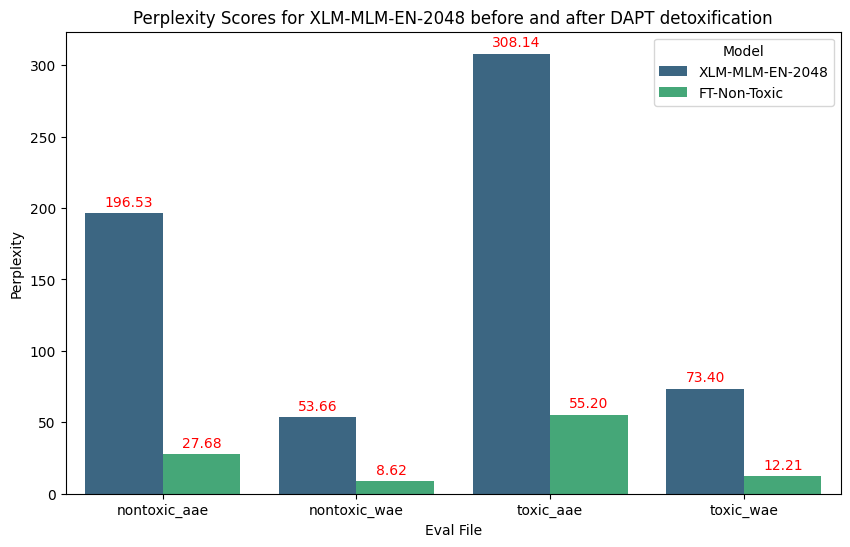

In [45]:
# plot the perplexity scores for the xlm-mlm-en-2048 model
plot_perplexity(eval_files, eval_results, ft_direct_eval_results, "XLM-MLM-EN-2048")

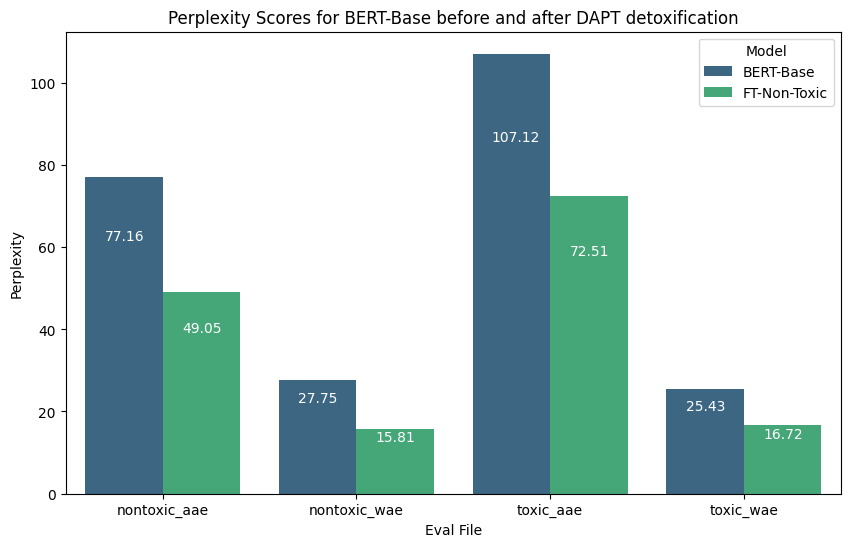

In [35]:
# plot the perplexity scores for the bert-base model and the fine-tuned model
plot_perplexity(eval_files, eval_results, ft_direct_eval_results, "BERT-Base")

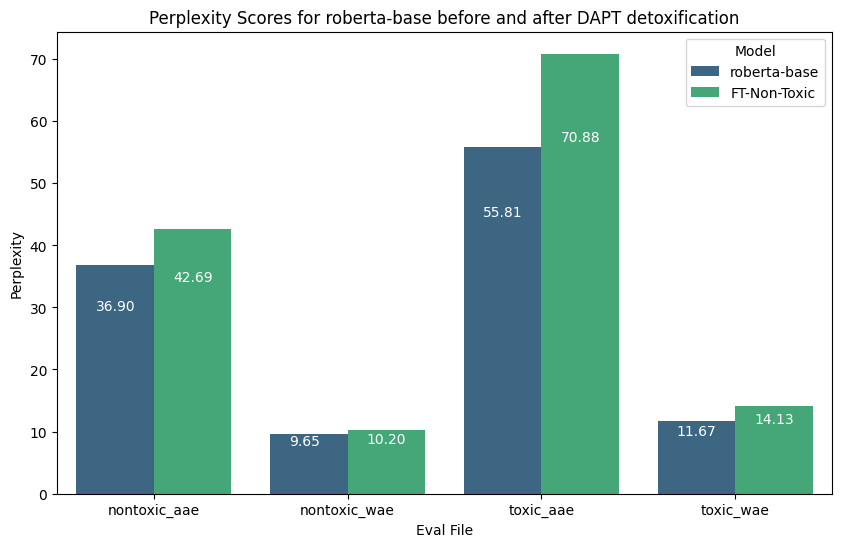

In [137]:
# plot the perplexity scores for the roberta-base model and the fine-tuned model
plot_perplexity(eval_files, eval_results, ft_direct_eval_results, base_model_path)

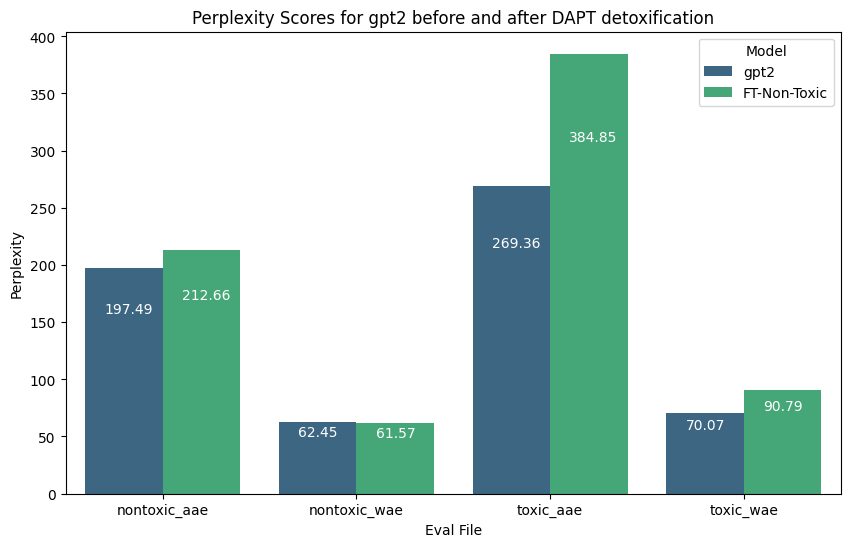

In [130]:
# plot the perplexity scores for the gpt2-medium and fine-tuned models
plot_perplexity(eval_files, eval_results, ft_direct_eval_results, base_model_path)